# Weather Data Pipeline with Python, Supabase, and MongoDB

This Jupyter Notebook implements a simple ETL (Extract, Transform, Load) pipeline to:
1. **Extract** weather data from the Open-Meteo API.
2. **Transform** the data by converting units and handling missing values.
3. **Load** the cleansed data into both a Supabase PostgreSQL database and a MongoDB collection.

## Prerequisites
- Python libraries: `python-dotenv`, `requests`, `pandas`, `supabase`, `pymongo`, `openmeteo-requests`, `requests-cache`, `retry-requests`
- A Supabase project[](https://supabase.com/)
- A MongoDB instance (e.g., Atlas) with credentials in `.env`

## Setup
1. Install libraries (next cell).
2. Create `.env`:
   ```
   SUPABASE_URL=your_url
   SUPABASE_KEY=your_key
   MONGO_URI=your_mongo_uri
   MONGO_DB_NAME=weather_db
   ```
3. In Colab: Upload `.env` with `files.upload()`.
4. Supabase table: `weather_data` (id SERIAL PK, city VARCHAR, temperature_kelvin FLOAT, humidity INTEGER, wind_speed FLOAT, timestamp TIMESTAMP).

## Step 0: Install Dependencies and Connect to Databases

### Install Dependencies

In [1]:
!pip install python-dotenv requests pandas supabase pymongo openmeteo-requests requests-cache retry-requests -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.1/680.1 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 61.8 MB/s eta 0:00:00


### Connect to Databases

You need to create a file in current directory that name `.env` with below content:
```markdown
SUPABASE_URL=https://<your-project-ref>.supabase.co
SUPABASE_KEY=<your_supabase_anon_key>
MONGO_URI=<your_mongodb_connection_string>
MONGO_DB_NAME=<your_database_name>
```

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

SUPABASE_URL = os.getenv('SUPABASE_URL')
SUPABASE_KEY = os.getenv('SUPABASE_KEY')
MONGO_URI = os.getenv('MONGO_URI')
MONGO_DB_NAME = os.getenv('MONGO_DB_NAME', 'weather_db')

print('Env loaded.')

Env loaded.


In [4]:
MONGO_DB_NAME

'weather_db'

### Connect to **Supabase**

In [5]:
from supabase import create_client, Client

supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)

print('Supabase ready.')

Supabase ready.


### Connect to **MongoDB**
Grant IP access for your client in MongoDB Atlas to enable secure connections.

**Steps:** Add your current IP to the access list. See [MongoDB - Configure IP Access List Entries](https://www.mongodb.com/docs/atlas/security/ip-access-list/) for details.

**Example:**  
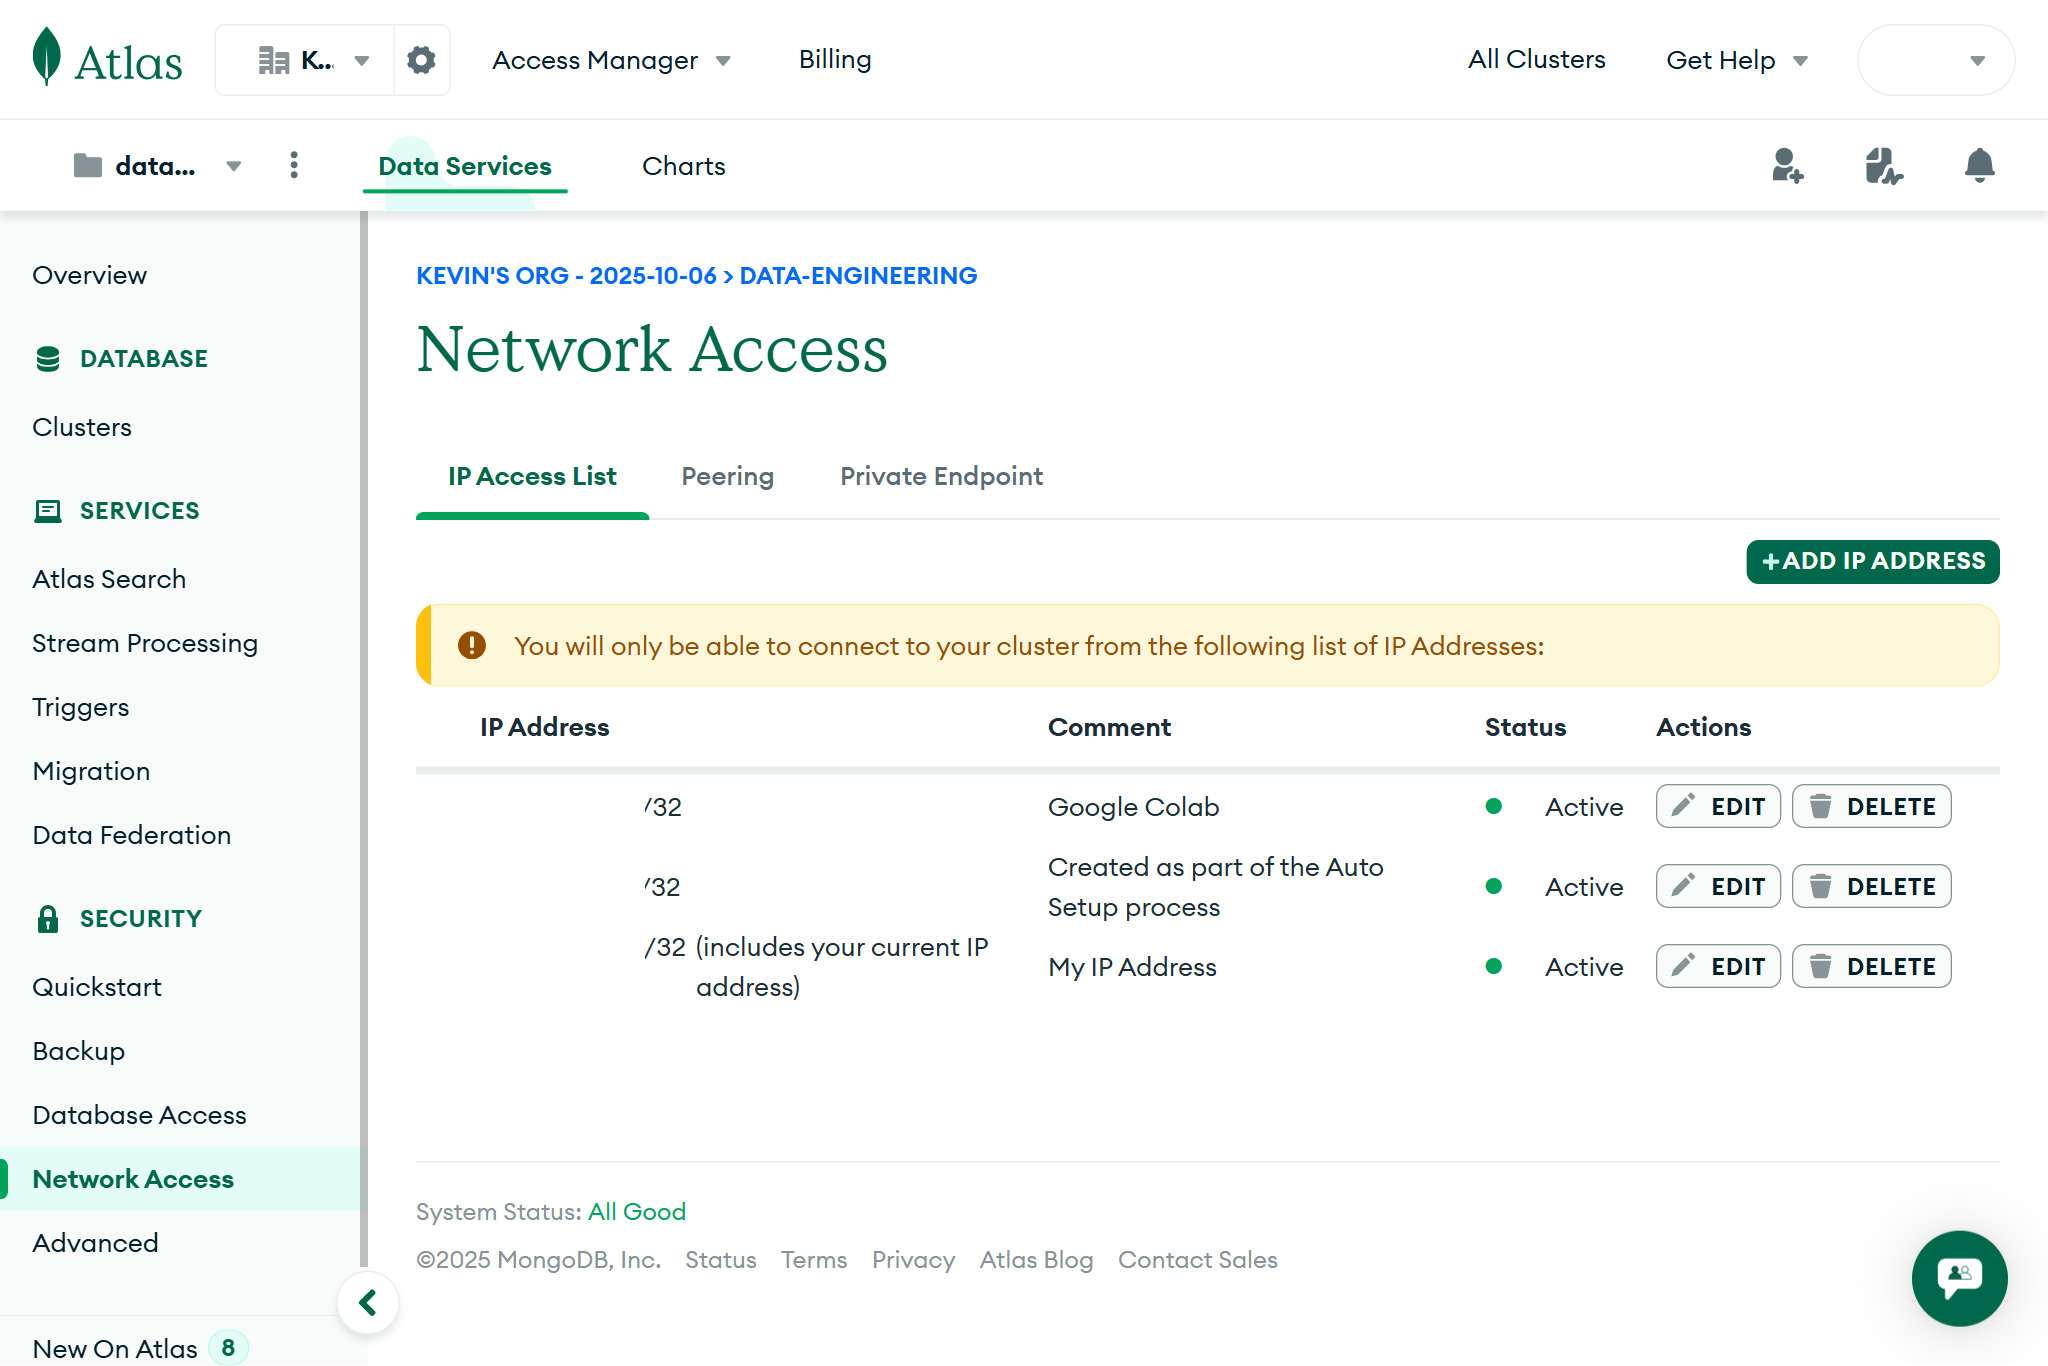
**Check current IP:**
```bash
curl -s https://ifconfig.me
```

In [6]:
import pymongo
mongo_client = pymongo.MongoClient(MONGO_URI)
mongo_db = mongo_client[MONGO_DB_NAME]
mongo_collection = mongo_db['weather_data']

print('MongoDB client ready.')

MongoDB client ready.


## Step 1: Extract

### Define Latitude and Longitude

In [7]:
city_coordinates = {
    'London': {'latitude': 51.5074, 'longitude': -0.1278},
    'New York': {'latitude': 40.7128, 'longitude': -74.0060},
    'Tokyo': {'latitude': 35.6762, 'longitude': 139.6503},
    'Sydney': {'latitude': -33.8688, 'longitude': 151.2093},
    'Paris': {'latitude': 48.8566, 'longitude': 2.3522}
}

### Get Data using **open-meteo** API

In [8]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"

# List to collect DataFrames for each city
city_dfs = []

for city, coords in city_coordinates.items():
    params = {
        "latitude": coords['latitude'],
        "longitude": coords['longitude'],
        "hourly": ["temperature_2m", "relative_humidity_2m", "rain", "snowfall", "dew_point_2m", "wind_speed_10m", "surface_pressure"],
        "wind_speed_unit": "mph",
        "temperature_unit": "fahrenheit",
        "precipitation_unit": "inch",
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process response (single location per city)
    for response in responses:
        # Process hourly data. The order of variables needs to be the same as requested.
        hourly = response.Hourly()
        hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
        hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
        hourly_rain = hourly.Variables(2).ValuesAsNumpy()
        hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()
        hourly_dew_point_2m = hourly.Variables(4).ValuesAsNumpy()
        hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()
        hourly_surface_pressure = hourly.Variables(6).ValuesAsNumpy()

        # Create date range for hourly timestamps (UTC)
        dates = pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            periods=len(hourly_temperature_2m),  # Use length of data arrays
            freq=pd.Timedelta(hours=1)  # Assuming hourly intervals
        )

        # Build dictionary for DataFrame: dates as index, variables as columns
        hourly_dict = {
            "city": [city] * len(dates),
            "date": dates,
            "temperature_2m": hourly_temperature_2m,
            "relative_humidity_2m": hourly_relative_humidity_2m,
            "rain": hourly_rain,
            "snowfall": hourly_snowfall,
            "dew_point_2m": hourly_dew_point_2m,
            "wind_speed_10m": hourly_wind_speed_10m,
            "surface_pressure": hourly_surface_pressure
        }

        # Create DataFrame for this city with MultiIndex (city, date)
        city_df = pd.DataFrame(hourly_dict)
        city_dfs.append(city_df)

# Concatenate all city DataFrames into one (stacks by MultiIndex)
hourly_dataframe = pd.concat(city_dfs, axis=0)

# Sort by MultiIndex (first city, then date) for cleaner output
hourly_dataframe = hourly_dataframe.sort_index()

In [9]:
hourly_dataframe.head()

,city,date,temperature_2m,relative_humidity_2m,rain,snowfall,dew_point_2m,wind_speed_10m,surface_pressure
0,London,2025-10-06 00:00:00+00:00,52.574898,74.0,0.0,0.0,44.525589,5.969060,1021.735962
0,Sydney,2025-10-06 00:00:00+00:00,82.186699,27.0,0.0,0.0,44.891731,5.816200,1002.081238
0,Paris,2025-10-06 00:00:00+00:00,53.536999,78.0,0.0,0.0,46.846706,6.502709,1021.087891
0,New York,2025-10-06 00:00:00+00:00,73.455803,63.0,0.0,0.0,60.094536,5.279510,1020.627197
0,Tokyo,2025-10-06 00:00:00+00:00,75.919998,84.0,0.0,0.0,70.736221,1.118500,1006.616333


## Step 2: Transform

- **Temperature**: °F → °C using $(F-32) \times \frac{5}{9}$.
- **Wind speed**: mph → m/s via the factor 0.44704 (or 0.514444 if the original unit is knots).
- **Humidity**: NaNs filled with 0 and cast to `int`.
- **Timestamp**: Converted to ISO‑8601 string (`YYYY‑MM‑DDTHH:MM:SS`).
- **Rounding**: Both temperature and wind speed rounded to two decimal places.
- **Column names**: Suffixed with `_c` for Celsius and `_ms` for meters‑per‑second.

In [10]:
# Post-processing transformations (adapted to our columns/units)
# 1. Fill NaNs in relative_humidity_2m (as 'humidity') and wind_speed_10m with 0
hourly_dataframe.fillna({
    'relative_humidity_2m': 0,
    'wind_speed_10m': 0
}, inplace=True)

# 2. Convert temperature_2m from °F to °C: (°F - 32) * 5/9
hourly_dataframe['temperature_2m'] = (hourly_dataframe['temperature_2m'] - 32) * 5/9

# 3. Convert wind_speed_10m from mph to m/s via knots intermediate if needed, but direct: 1 mph ≈ 0.44704 m/s
# (Note: If raw was knots, use 1 knot ≈ 0.514444 m/s; here from mph for accuracy)
hourly_dataframe['wind_speed_10m'] = hourly_dataframe['wind_speed_10m'] * 0.44704

# 4. Cast relative_humidity_2m (as 'humidity') to int
hourly_dataframe['relative_humidity_2m'] = hourly_dataframe['relative_humidity_2m'].astype(int)

# 5. Reset index to transform 'date' to string timestamp, then re-set MultiIndex
# hourly_dataframe = hourly_dataframe.reset_index()
hourly_dataframe['timestamp'] = pd.to_datetime(hourly_dataframe['date']).dt.strftime('%Y-%m-%dT%H:%M:%S')
hourly_dataframe = hourly_dataframe.drop('date', axis=1)  # Drop original date
# hourly_dataframe = hourly_dataframe.set_index(['city', 'timestamp'])

# 6. Round temperature_2m (now in °C) and wind_speed_10m (now in m/s) to 2 decimals
hourly_dataframe['temperature_2m'] = hourly_dataframe['temperature_2m'].round(2)
hourly_dataframe['wind_speed_10m'] = hourly_dataframe['wind_speed_10m'].round(2)

# 7. Rename columns to reflect units
hourly_dataframe.rename(columns={
    'temperature_2m': 'temperature_2m_c',
    'wind_speed_10m': 'wind_speed_10m_ms'
}, inplace=True)

print('Transformed:')
hourly_dataframe.head()

Transformed:


,city,temperature_2m_c,relative_humidity_2m,rain,snowfall,dew_point_2m,wind_speed_10m_ms,surface_pressure,timestamp
0,London,11.430000,74,0.0,0.0,44.525589,2.67,1021.735962,2025-10-06T00:00:00
0,Sydney,27.879999,27,0.0,0.0,44.891731,2.60,1002.081238,2025-10-06T00:00:00
0,Paris,11.960000,78,0.0,0.0,46.846706,2.91,1021.087891,2025-10-06T00:00:00
0,New York,23.030001,63,0.0,0.0,60.094536,2.36,1020.627197,2025-10-06T00:00:00
0,Tokyo,24.400000,84,0.0,0.0,70.736221,0.50,1006.616333,2025-10-06T00:00:00


## Step 3: Load

Store the cleansed data in a Supabase PostgreSQL database.

**Note**: Ensure a table named `weather_data` exists in your Supabase database with the following schema:
```sql
CREATE TABLE weather_data (
    id SERIAL PRIMARY KEY,
    city VARCHAR(100),
    temperature_2m_C FLOAT,
    relative_humidity_2m INTEGER,
    rain FLOAT,
    snowfall FLOAT,
    dew_point_2m FLOAT,
    wind_speed_10m_ms FLOAT,
    surface_pressure FLOAT,
    timestamp TIMESTAMP
);
```

### Define `data_to_insert`

In [11]:
data_to_insert = hourly_dataframe.to_dict(orient='records')

### Insert to Supabase

In [12]:
# Supabase
try:
    supabase.table('weather_data').insert(data_to_insert).execute()
    print('✅ Supabase loaded!')
except Exception as e:
    print(f'❌ Supabase: {e}')

✅ Supabase loaded!


In [13]:
# Verify
supa_data = supabase.table('weather_data').select('*').execute().data
print('\nSupabase:')
display(pd.DataFrame(supa_data))


Supabase:


,id,city,temperature_2m_c,relative_humidity_2m,rain,snowfall,dew_point_2m,wind_speed_10m_ms,surface_pressure,timestamp
0,1,London,11.430000,74,0.000000,0,44.525589,2.67,1021.735962,2025-10-06T00:00:00
1,2,Sydney,27.879999,27,0.000000,0,44.891731,2.60,1002.081238,2025-10-06T00:00:00
2,3,Paris,11.960000,78,0.000000,0,46.846706,2.91,1021.087891,2025-10-06T00:00:00
3,4,New York,23.030001,63,0.000000,0,60.094536,2.36,1020.627197,2025-10-06T00:00:00
4,5,Tokyo,24.400000,84,0.000000,0,70.736221,0.50,1006.616333,2025-10-06T00:00:00
...,...,...,...,...,...,...,...,...,...,...
835,836,New York,12.730000,82,0.019685,0,49.516441,9.78,1008.736572,2025-10-12T23:00:00
836,837,Sydney,18.379999,40,0.000000,0,40.166561,1.72,1009.584045,2025-10-12T23:00:00
837,838,Paris,12.550000,86,0.000000,0,50.485847,2.08,1024.283081,2025-10-12T23:00:00
838,839,Tokyo,22.450001,84,0.000000,0,67.294083,1.93,1011.367798,2025-10-12T23:00:00


### Insert to MongoDB

In [17]:
# MongoDB
try:
    result = mongo_collection.insert_many(data_to_insert)
    print(f'✅ MongoDB loaded! ({len(result.inserted_ids)} docs)')
except Exception as e:
    print(f'❌ MongoDB: {e}')


✅ MongoDB loaded! (840 docs)


In [18]:
# Verify
mongo_data = list(mongo_collection.find({}, {'_id': 0}).limit(5))
print('\nMongoDB:')
display(pd.DataFrame(mongo_data))


MongoDB:


,city,temperature_2m_c,relative_humidity_2m,rain,snowfall,dew_point_2m,wind_speed_10m_ms,surface_pressure,timestamp
0,London,11.430000,74,0.0,0.0,44.525589,2.67,1021.735962,2025-10-06T00:00:00
1,Sydney,27.879999,27,0.0,0.0,44.891731,2.60,1002.081238,2025-10-06T00:00:00
2,Paris,11.960000,78,0.0,0.0,46.846706,2.91,1021.087891,2025-10-06T00:00:00
3,New York,23.030001,63,0.0,0.0,60.094536,2.36,1020.627197,2025-10-06T00:00:00
4,Tokyo,24.400000,84,0.0,0.0,70.736221,0.50,1006.616333,2025-10-06T00:00:00


## Conclusion
ETL complete! Extend with more cities or scheduling.